# 4-CRU Mechanism Kinematic Calculation Handbook

In [1]:
from __future__ import print_function
import numpy as np
import numpy.matlib
import numpy.linalg as la
import math
from sympy import * # symbolic calculation for IK
#import transformations.py as tfs 
import transformations as tfs
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

# check the environment and directory of the notebook
import sys
sys.path

['C:\\Users\\chawi\\OneDrive\\MechE MS-PhD\\Jupyter_notebook\\4-CRU_mechnism_project\\4-CRU_mechanism_analysis',
 'C:\\Users\\chawi\\Anaconda3\\python37.zip',
 'C:\\Users\\chawi\\Anaconda3\\DLLs',
 'C:\\Users\\chawi\\Anaconda3\\lib',
 'C:\\Users\\chawi\\Anaconda3',
 '',
 'C:\\Users\\chawi\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\chawi\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\chawi\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\chawi\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\chawi\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\chawi\\.ipython']

## Important Notes
1. This notebook must be run in conda environment (python 3 kernel)
2. Always put transformations.py in the same directory as this notebook

## Jupyter Notebook Tips and Tricks
1. https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
2. https://hub.packtpub.com/basics-jupyter-notebook-python/
3. Installing Python Kernel https://ipython.readthedocs.io/en/latest/install/kernel_install.html
4. Update Python 3.5 in Ubuntu 16.04 to 3.6+ http://ubuntuhandbook.org/index.php/2017/07/install-python-3-6-1-in-ubuntu-16-04-lts/

## Notes on [Transformation.py](https://github.com/ROAR-Lab-Spine/geometry/blob/melodic-devel/tf/src/tf/transformations.py)


1. Quaternions $q = ix+jy+kz+w$ are represented as $[x, y, z, w ]$= $[x_1, x_2, x_3, x_0]$.

## Notes on [SymPy’s documentation](https://docs.sympy.org/latest/index.html)

1. [Matrix Functions](https://docs.sympy.org/latest/modules/matrices/common.html?highlight=transpose#sympy.matrices.common.MatrixCommon.transpose)
2. [Matrix Operations](https://docs.sympy.org/latest/modules/matrices/matrices.html?highlight=matrix%20operation)
3. [Polynomial and Groebner bases¶](https://docs.sympy.org/latest/modules/polys/basics.html?highlight=polynomial%20solve)
4. Primary Decomposition

## Notes on SINGULAR
1. [Related Publications](https://www.singular.uni-kl.de/index.php/publications/singular-related-publications.html)

In [2]:
tf_init = tfs.identity_matrix()
# print tf_init
des_quat = tfs.quaternion_about_axis(0, (0, 0, 1))
des_xyz = np.array([0,0,0.1])
print(des_quat)
print(des_xyz)

[0. 0. 0. 1.]
[0.  0.  0.1]


In [3]:
# Set up Symbolic variables
X, Y, Z = symbols('X, Y, Z')
x_0, x_1, x_2, x_3 = symbols('x_0, x_1, x_2, x_3')
a, b, c, d = symbols('a, b, c, d')
h_1, h_2, h_3, h_4 = symbols('h_1, h_2, h_3, h_4')
r = symbols('r')

In [4]:
# Position of the C joint with respect to the base frame
r0_B1 = Matrix([a, -b, h_1, 1])
r1_C1 = Matrix([c, -d, 0, 1])

r0_B2 = Matrix([a, b, h_2, 1])
r1_C2 = Matrix([c, d, 0, 1])

r0_B3 = Matrix([-a, b, h_3, 1])
r1_C3 = Matrix([-c, d, 0, 1])

r0_B4 = Matrix([-a, -b, h_4, 1])
r1_C4 = Matrix([-c, -d, 0, 1])

In [5]:
R0_1 = Matrix([[x_0**2 + x_1**2 - x_2**2 - x_3**2, 2.0*(x_1*x_2 - x_0*x_3), 2.0*(x_0*x_2 + x_1*x_3)],
                [2.0*(x_0*x_3 + x_1*x_2),x_0**2 - x_1**2 + x_2**2 - x_3**2,2.0*(x_2*x_3 - x_0*x_1)],
                [2.0*(x_1*x_3 - x_0*x_2),2.0*(x_0*x_1 + x_2*x_3),x_0**2 - x_1**2 - x_2**2 + x_3**2]])
r0_1 = Matrix([X, Y, Z, 1.0])  
T0_1 = R0_1.col_join(zeros(1,3))
T0_1 = T0_1.row_join(r0_1)
T0_1

Matrix([
[x_0**2 + x_1**2 - x_2**2 - x_3**2,        -2.0*x_0*x_3 + 2.0*x_1*x_2,         2.0*x_0*x_2 + 2.0*x_1*x_3,   X],
[        2.0*x_0*x_3 + 2.0*x_1*x_2, x_0**2 - x_1**2 + x_2**2 - x_3**2,        -2.0*x_0*x_1 + 2.0*x_2*x_3,   Y],
[       -2.0*x_0*x_2 + 2.0*x_1*x_3,         2.0*x_0*x_1 + 2.0*x_2*x_3, x_0**2 - x_1**2 - x_2**2 + x_3**2,   Z],
[                                0,                                 0,                                 0, 1.0]])

In [6]:
# Vector along the U-U Rods
u0_1 = T0_1*r1_C1 - r0_B1
u0_2 = T0_1*r1_C2 - r0_B2
u0_3 = T0_1*r1_C3 - r0_B3
u0_4 = T0_1*r1_C4 - r0_B4

In [7]:
r0_ee_to_C2 = T0_1*r1_C2
r0_ee_to_C2 = r0_ee_to_C2.subs([(X, 0),(Y, 0),(Z, 0)])

In [8]:
# Scalar Triple Product 
f_5 = simplify(expand(u0_1.dot(u0_1))) - r**2
f_6 = simplify(expand(u0_2.dot(u0_2))) - r**2
f_7 = simplify(expand(u0_3.dot(u0_3))) - r**2
f_8 = simplify(expand(u0_4.dot(u0_4))) - r**2
f_9 = x_0**2+x_1**2+x_2**2+x_3**2-1.0

# Substitute Additional Mode Geometric Condition A
f_5A = f_5.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_6A = f_6.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_7A = f_7.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_8A = f_8.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_9A = f_9.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)

In [9]:
f_9A_sq = f_9A*f_9A
f_9A_sq_expd = expand(f_9A_sq)
f_9A_sq

(x_0**2 + x_1**2 - 1.0)**2

In [10]:
f_9A_sq_expd.subs(-2.0*x_0**2-2.0*x_1**2, -2)

x_0**4 + 2*x_0**2*x_1**2 - 2.0*x_0**2 + x_1**4 - 2.0*x_1**2 + 1.0

In [11]:
f_9A_sq_expd

x_0**4 + 2*x_0**2*x_1**2 - 2.0*x_0**2 + x_1**4 - 2.0*x_1**2 + 1.0

In [12]:
f_5A = collect(f_5A, (X,Y,Z,r,a,b,c,d))
f_5A

Y**2 + Y*(2*b - 2*d*x_0**2 + 2*d*x_1**2) + Z**2 + Z*(-4.0*d*x_0*x_1 - 2*h_1) + a**2*(x_0**4 + 2*x_0**2*x_1**2 - 2*x_0**2 + x_1**4 - 2*x_1**2 + 1) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2*(x_0**4 + 2.0*x_0**2*x_1**2 + x_1**4) + 4.0*d*h_1*x_0*x_1 + h_1**2 - r**2

In [13]:
# eliminate the quaternion identity
f_5A = f_5A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_5A = f_5A.subs(f_9A_sq_expd-1.0,-1.0)
f_5A

Y**2 + Y*(2*b - 2*d*x_0**2 + 2*d*x_1**2) + Z**2 + Z*(-4.0*d*x_0*x_1 - 2*h_1) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 + 4.0*d*h_1*x_0*x_1 + h_1**2 - r**2

In [14]:
f_6A = collect(f_6A, (X,Y,Z,r,a,b,c,d))
f_6A = f_6A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_6A = f_6A.subs(f_9A_sq_expd-1.0,-1.0)
f_6A

Y**2 + Y*(-2*b + 2*d*x_0**2 - 2*d*x_1**2) + Z**2 + Z*(4.0*d*x_0*x_1 - 2*h_2) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 - 4.0*d*h_2*x_0*x_1 + h_2**2 - r**2

In [15]:
f_7A = collect(f_7A, (X,Y,Z,r,a,b,c,d))
f_7A = f_7A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_7A = f_7A.subs(f_9A_sq_expd-1.0,-1.0)
f_7A

Y**2 + Y*(-2*b + 2*d*x_0**2 - 2*d*x_1**2) + Z**2 + Z*(4.0*d*x_0*x_1 - 2*h_3) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 - 4.0*d*h_3*x_0*x_1 + h_3**2 - r**2

In [16]:
f_8A = collect(f_8A, (X,Y,Z,r,a,b,c,d))
f_8A = f_8A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_8A = f_8A.subs(f_9A_sq_expd-1.0,-1.0)
f_7A

Y**2 + Y*(-2*b + 2*d*x_0**2 - 2*d*x_1**2) + Z**2 + Z*(4.0*d*x_0*x_1 - 2*h_3) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 - 4.0*d*h_3*x_0*x_1 + h_3**2 - r**2

# Inverse Kinematics (Schoenfiles Mode)

In [17]:
# Schonflies Mode
# T0_1_H1 = T0_1.subs([(x_1, 0),(x_2, 0)],simultaneous=True)
des_pose = tfs.identity_matrix()

f_5_H1 = f_5.subs([(X, des_xyz[0]),
                   (Y, des_xyz[1]),
                   (Z, des_xyz[2]),
                   (x_1, des_quat[0]),
                   (x_2, des_quat[1]),
                   (x_3, des_quat[2]),
                   (x_0, des_quat[3])],
                  simultaneous=True) 
h_1_sols = solve(f_5_H1, h_1)

In [18]:
h_2_sols = solve(f_6, h_2)
h_2_sols[1].subs([(x_1, 0),(x_2,0)])
# We can change the signs of a,b,c,d corresponding to the 

Z + sqrt(-X**2 + 2.0*X*a - 2.0*X*c*x_0**2 + 2.0*X*c*x_3**2 + 4.0*X*d*x_0*x_3 - Y**2 + 2.0*Y*b - 4.0*Y*c*x_0*x_3 - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_3**2 - a**2 + 2.0*a*c*x_0**2 - 2.0*a*c*x_3**2 - 4.0*a*d*x_0*x_3 - b**2 + 4.0*b*c*x_0*x_3 + 2.0*b*d*x_0**2 - 2.0*b*d*x_3**2 - c**2*x_0**4 - 2.0*c**2*x_0**2*x_3**2 - c**2*x_3**4 - d**2*x_0**4 - 2.0*d**2*x_0**2*x_3**2 - d**2*x_3**4 + r**2)

# Inverse Kinematics (Additional Mode: Geometric A)

In [19]:
# Additional Mode (Geometric A)
g_1A = factor(f_5A - f_8A)
g_1A

4.0*(1.0*h_1 - 1.0*h_4)*(-0.5*Z + 1.0*d*x_0*x_1 + 0.25*h_1 + 0.25*h_4)

In [20]:
g_2A = factor(f_5A + f_8A)
g_2A

-8.0*(-0.25*Y**2 - 0.5*Y*b + 0.5*Y*d*x_0**2 - 0.5*Y*d*x_1**2 - 0.25*Z**2 + 1.0*Z*d*x_0*x_1 + 0.25*Z*h_1 + 0.25*Z*h_4 - 0.25*b**2 + 0.5*b*d*x_0**2 - 0.5*b*d*x_1**2 - 0.25*d**2 - 0.5*d*h_1*x_0*x_1 - 0.5*d*h_4*x_0*x_1 - 0.125*h_1**2 - 0.125*h_4**2 + 0.25*r**2)

In [21]:
g_3A = factor(f_6A - f_7A)
g_3A = g_3A .args[1]*(g_3A.args[0]*g_3A.args[2])
g_3A

(1.0*h_2 - 1.0*h_3)*(-2.0*Z - 4.0*d*x_0*x_1 + 1.0*h_2 + 1.0*h_3)

In [22]:
g_4A = expand(factor(f_6A + f_7A))
g_4A

2.0*Y**2 - 4.0*Y*b + 4.0*Y*d*x_0**2 - 4.0*Y*d*x_1**2 + 2.0*Z**2 + 8.0*Z*d*x_0*x_1 - 2.0*Z*h_2 - 2.0*Z*h_3 + 2.0*b**2 - 4.0*b*d*x_0**2 + 4.0*b*d*x_1**2 + 2.0*d**2 - 4.0*d*h_2*x_0*x_1 - 4.0*d*h_3*x_0*x_1 + 1.0*h_2**2 + 1.0*h_3**2 - 2.0*r**2

In [23]:
# Reduce to 3 Equations 
e_1A = expand(factor(g_2A.subs(h_1, h_4)))/2
e_1A

Y**2 + 2.0*Y*b - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_1**2 + Z**2 - 4.0*Z*d*x_0*x_1 - 2.0*Z*h_4 + b**2 - 2.0*b*d*x_0**2 + 2.0*b*d*x_1**2 + d**2 + 4.0*d*h_4*x_0*x_1 + h_4**2 - 1.0*r**2

In [24]:
#***Choose the factor that does not lead to actuation singularity configuration
e_2A = g_3A.args[1]
e_2A

-2.0*Z - 4.0*d*x_0*x_1 + 1.0*h_2 + 1.0*h_3

In [25]:
e_3A = g_4A
e_3A
factor(e_3A)

-8.0*(-0.25*Y**2 + 0.5*Y*b - 0.5*Y*d*x_0**2 + 0.5*Y*d*x_1**2 - 0.25*Z**2 - 1.0*Z*d*x_0*x_1 + 0.25*Z*h_2 + 0.25*Z*h_3 - 0.25*b**2 + 0.5*b*d*x_0**2 - 0.5*b*d*x_1**2 - 0.25*d**2 + 0.5*d*h_2*x_0*x_1 + 0.5*d*h_3*x_0*x_1 - 0.125*h_2**2 - 0.125*h_3**2 + 0.25*r**2)

In [26]:
# solve for h_4 (=h_1), h_2, and h_3

# invs_kin_sols_geo_A = solve((e_1A, e_2A, e_3A), (h_2, h_3, h_4))
# invs_kin_sols_geo_A

h_1_h_4_sol = simplify(solve(e_1A, h_4))
h_1_h_4_sol[0]

Z - 2.0*d*x_0*x_1 - sqrt(-Y**2 - 2.0*Y*b + 2.0*Y*d*x_0**2 - 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2)

In [27]:
# https://stackoverflow.com/questions/53092738/eliminate-a-variable-to-relate-two-functions-in-python-using-sympy
# https://github.com/sympy/sympy/issues/2720
d_1A = factor(e_3A.subs(h_2, solve(e_2A, h_2)[0]))
h_3_sol = solve((d_1A,f_9A), h_3)

In [28]:
print(h_3_sol[1][0])

Z + 2.0*d*x_0*x_1 + sqrt(-Y**2 + 2.0*Y*b - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2)


In [29]:
h_2_sol = (solve(e_2A, h_2)[0]).subs(h_3, h_3_sol[1][0])
h_2_sol

1.0*Z + 2.0*d*x_0*x_1 - sqrt(-Y**2 + 2.0*Y*b - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2)

# Forward Kinematics (Schoenfiles Mode)

# Trajectory Simulation 

# Robot Class 

In [48]:
class Robot4CRU(object):
    """class of Robot_4CRU"""
    def __init__(self):
        super(Robot4CRU, self).__init__()
        self.set_geometric_params([0, 0, 1, 4]) # A min alpha, beta = 45 deg, long ee diag length, long base diag length
        self.set_geometric_params([4, 0, 1, 4]) # B max alpha, beta = 45 deg, long ee diag length, long base diag length
        self.operation_mode = "H1" # 0 = Schoenfiles, 1 = Additional, 2 = Reverse Schoenfiles
        
    def set_geometric_params(self, new_geometric_indcs):
        # End-effector joint axis distribution angles (5 cases)
        self.alphas = np.sort(np.array([np.pi/4.0, np.pi/4.0 + np.pi/8.0, np.pi/2.0, np.pi/2.0 + np.pi/8.0, np.pi/2.0 + np.pi/4.0])/2.0)
        # Base joint axis distribution angles (2 cases)
        self.betas = np.sort(np.array([np.pi/4.0, np.pi/4.0 + np.pi/8.0]))
        # end effector diagonal lengths (2 cases) unit in mm
        self.eeff_diag_lengths = np.sort(np.array([6.25/np.cos(np.pi/8)-2.0, 6.25/np.cos(np.pi/8)]))*25.4
        # base diagonal length (5 cases) unit in mm
        self.base_diag_lengths = np.sort(np.array([self.eeff_diag_lengths[0],
            self.eeff_diag_lengths[1],
            self.eeff_diag_lengths[0]*np.cos(self.alphas[1])/np.cos(self.betas[0]), 
            self.eeff_diag_lengths[1]*np.cos(self.alphas[0])/np.cos(self.betas[0]),
            self.eeff_diag_lengths[1]*np.cos(self.alphas[1])/np.cos(self.betas[0])]))
        # length of the UU couple (from CAD) unit in mm
        self.r = (1.75*2 + 2.54*2)*10.0
        self.joint_pos_range = np.array([0, 300.00])
        self.joint_pos = np.full(4, self.joint_pos_range[1]/2.0) # home position
        #self.h_offset = 3.0*25.4 # (approx.) TODO: update from real CAD
        self.h_offset = 0 # not offset in simulation

        self.geometric_indcs = new_geometric_indcs
        self.a = self.base_diag_lengths[self.geometric_indcs[3]]/2.0*np.cos(self.betas[self.geometric_indcs[1]])
        self.b = self.base_diag_lengths[self.geometric_indcs[3]]/2.0*np.sin(self.betas[self.geometric_indcs[1]])
        self.c = self.eeff_diag_lengths[self.geometric_indcs[2]]/2.0*np.cos(self.alphas[self.geometric_indcs[0]])
        self.d = self.eeff_diag_lengths[self.geometric_indcs[2]]/2.0*np.sin(self.alphas[self.geometric_indcs[0]])
        self.update_geometric_cond()
        
    def update_geometric_cond(self):
        curr_a = round(self.a, 3) # magnitude only
        curr_b = round(self.b, 3)
        curr_c = round(self.c, 3)
        curr_d = round(self.d, 3)
        if (curr_a < curr_c and curr_b > curr_d) or (curr_a > curr_c and curr_b < curr_d):
            self.geometric_cond = "Generic"
        elif curr_a == curr_c and curr_b != curr_d:
            self.geometric_cond = "A"
        elif curr_a != curr_c and curr_b == curr_d:
            self.geometric_cond = "B"
        elif curr_a == curr_c and curr_b == curr_d:
            self.geometric_cond = "C"
        else:
            self.geometric_cond = "Other"
            print("Additional Mode is not achievable!")
        print("Geometric Condition: ", self.geometric_cond)
        print("[a, b, c, d] = ", [self.a, self.b, self.c, self.d], " mm")
        print("r = ", self.r, " mm")
        
    def inverse_kinematics(self, des_pose_4dof):
        reals, discriminants, has_solution = self.check_ik_feasible(des_pose_4dof)
        all_joint_pos_sol = np.full((4, 2), self.joint_pos_range[1]/2.0) # home position as default value
        all_swivel_angles = np.zeros((4, 2)) # indices [joint_no, U1/U2]
        current_joint_pos = self.joint_pos
        selected_joint_pos_sol = current_joint_pos
        if has_solution:
            for i in range(4):
                for j in range(2):
                    if j == 0:
                        all_joint_pos_sol[i,j] = reals[i] - np.sqrt(discriminants[i]) - self.h_offset
                    elif j == 1:
                        all_joint_pos_sol[i,j] = reals[i] + np.sqrt(discriminants[i]) - self.h_offset
                    swivel_angle_U1, swivel_angle_U2 = self.calc_swivel_angle(des_pose_4dof, all_joint_pos_sol[i,1], i)
                    all_swivel_angles[i,0] = swivel_angle_U1
                    all_swivel_angles[i,1] = swivel_angle_U2
                #joint_pos_diff_j_index = np.argmin(np.abs(all_joint_pos_sol[i,:] - current_joint_pos[i]))
                #selected_joint_pos_sol[i] = all_joint_pos_sol[i, joint_pos_diff_j_index]
                joint_pos_sol_index = np.array([1,0,1,0])
                selected_joint_pos_sol[i] = all_joint_pos_sol[i, joint_pos_sol_index[i]]
        else:
            # if no solution, return current joint positions
            print("No IK Solution: at least one discriminant is negative: ", discriminants)

        # check the swivel angle limit on both ends of the U-U rod: provide warning on the screen if the joint are out of ranges
        print("IK joint pos solutions: ", selected_joint_pos_sol)
        #print("swivel angles (deg): ", np.rad2deg(all_swivel_angles))

        return selected_joint_pos_sol.tolist()
    
    def check_ik_feasible(self, pose_4dof):
        tf_mat_base_to_eeff, X, Y, Z, x_0, x_1, x_2, x_3 = self.convert_pose_4dof_to_tf_mat_and_7var(pose_4dof)
        r = self.r
    
        reals = np.zeros([4])
        discriminants = np.zeros([4])
        has_solution = True

        for i in range(4):
            # convert signs based on joint indices
            if i == 0:
                a = self.a; b = -self.b; c = self.c; d = -self.d
            elif i == 1:
                a = self.a; b = self.b; c = self.c; d = self.d
            elif i == 2:
                a = -self.a; b = self.b; c = -self.c; d = self.d
            elif i == 3:
                a = -self.a; b = -self.b; c = -self.c; d = -self.d

            discriminants[i] = -X**2 + 2.0*X*a - 2.0*X*c*x_0**2 - 2.0*X*c*x_1**2 + \
            2.0*X*c*x_2**2 + 2.0*X*c*x_3**2 + 4.0*X*d*x_0*x_3 - 4.0*X*d*x_1*x_2 \
            - Y**2 + 2.0*Y*b - 4.0*Y*c*x_0*x_3 - 4.0*Y*c*x_1*x_2 - \
            2.0*Y*d*x_0**2 + 2.0*Y*d*x_1**2 - 2.0*Y*d*x_2**2 + 2.0*Y*d*x_3**2 - \
            a**2 + 2.0*a*c*x_0**2 + 2.0*a*c*x_1**2 - 2.0*a*c*x_2**2 - \
            2.0*a*c*x_3**2 - 4.0*a*d*x_0*x_3 + 4.0*a*d*x_1*x_2 - b**2 + \
            4.0*b*c*x_0*x_3 + 4.0*b*c*x_1*x_2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 \
            + 2.0*b*d*x_2**2 - 2.0*b*d*x_3**2 - c**2*x_0**4 - \
            2.0*c**2*x_0**2*x_1**2 + 2.0*c**2*x_0**2*x_2**2 - \
            2.0*c**2*x_0**2*x_3**2 - 8.0*c**2*x_0*x_1*x_2*x_3 - c**2*x_1**4 - \
            2.0*c**2*x_1**2*x_2**2 + 2.0*c**2*x_1**2*x_3**2 - c**2*x_2**4 - \
            2.0*c**2*x_2**2*x_3**2 - c**2*x_3**4 - 8.0*c*d*x_0**2*x_1*x_2 + \
            8.0*c*d*x_0*x_1**2*x_3 - 8.0*c*d*x_0*x_2**2*x_3 + \
            8.0*c*d*x_1*x_2*x_3**2 - d**2*x_0**4 + 2.0*d**2*x_0**2*x_1**2 - \
            2.0*d**2*x_0**2*x_2**2 - 2.0*d**2*x_0**2*x_3**2 + \
            8.0*d**2*x_0*x_1*x_2*x_3 - d**2*x_1**4 - 2.0*d**2*x_1**2*x_2**2 - \
            2.0*d**2*x_1**2*x_3**2 - d**2*x_2**4 + 2.0*d**2*x_2**2*x_3**2 - \
            d**2*x_3**4 + r**2  

            reals[i] = Z - 2.0*c*x_0*x_2 + 2.0*c*x_1*x_3 + 2.0*d*x_0*x_1 + 2.0*d*x_2*x_3

        if np.any(np.sign(discriminants) < 0):
            has_solution = False

        return reals, discriminants, has_solution
    
    def calc_swivel_angle(self, des_pose_4dof, joint_pos, joint_index):
        tf_mat_base_to_eeff, X, Y, Z, x_0, x_1, x_2, x_3 = self.convert_pose_4dof_to_tf_mat_and_7var(des_pose_4dof)
        
        # convert signs based on joint indices
        if joint_index == 0:
            a = self.a; b = -self.b; c = self.c; d = -self.d
        elif joint_index == 1:
            a = self.a; b = self.b; c = self.c; d = self.d
        elif joint_index == 2:
            a = -self.a; b = self.b; c = -self.c; d = self.d
        elif joint_index == 3:
            a = -self.a; b = -self.b; c = -self.c; d = -self.d

        u0_B_to_C = np.array([X - a + c*(x_0**2 + x_1**2 - x_2**2 - x_3**2) + d*(-2.0*x_0*x_3 + 2.0*x_1*x_2),
            Y - b + c*(2.0*x_0*x_3 + 2.0*x_1*x_2) + d*(x_0**2 - x_1**2 + x_2**2 - x_3**2),
            Z + c*(-2.0*x_0*x_2 + 2.0*x_1*x_3) + d*(2.0*x_0*x_1 + 2.0*x_2*x_3) - joint_pos - self.h_offset])
        v0_C_to_ee = -np.array([c*(x_0**2 + x_1**2 - x_2**2 - x_3**2) + d*(-2.0*x_0*x_3 + 2.0*x_1*x_2),
            c*(2.0*x_0*x_3 + 2.0*x_1*x_2) + d*(x_0**2 - x_1**2 + x_2**2 - x_3**2),
            c*(-2.0*x_0*x_2 + 2.0*x_1*x_3) + d*(2.0*x_0*x_1 + 2.0*x_2*x_3)])
        v0_B_to_base = -np.array([a, b, 0])

        swivel_angle_U1 = py_ang(u0_B_to_C, v0_B_to_base)
        swivel_angle_U2 = py_ang(v0_C_to_ee, u0_B_to_C)

        return swivel_angle_U1, swivel_angle_U2
    
    def convert_pose_4dof_to_tf_mat_and_7var(self, pose_4dof):
        if self.operation_mode == "H1":
            t_mat = tfs.translation_matrix((pose_4dof[0], pose_4dof[1], pose_4dof[2]))
            r_mat = tfs.rotation_matrix(pose_4dof[3], (0, 0, 1))
            tf_mat_base_to_eeff = tfs.concatenate_matrices(t_mat, r_mat)
        if self.operation_mode == "H3":
            # break down to geometric cases
            pass
        else:
            pass

        X, Y, Z, x_0, x_1, x_2, x_3 = convert_tf_mat_to_7var(tf_mat_base_to_eeff)

        return tf_mat_base_to_eeff, X, Y, Z, x_0, x_1, x_2, x_3

def convert_tf_mat_to_7var(tf_mat):
    quat = tfs.quaternion_from_matrix(tf_mat)
    xyz = tfs.translation_from_matrix(tf_mat)
    X = xyz[0]; Y = xyz[1]; Z = xyz[2] 
    x_0 = quat[3]; x_1 = quat[0]; x_2 = quat[1]; x_3 = quat[2]
    return X, Y, Z, x_0, x_1, x_2, x_3

def py_ang(v1, v2):
        """ Returns the angle in radians between vectors 'v1' and 'v2'    """
        cosang = np.dot(v1, v2)
        sinang = la.norm(np.cross(v1, v2))
        return np.arctan2(sinang, cosang)

In [38]:
# create a robot 
robot = Robot4CRU()

Geometric Condition:  A
[a, b, c, d] =  [79.375, 79.375, 79.375, 32.878201513364424]  mm
r =  85.8  mm
Geometric Condition:  B
[a, b, c, d] =  [79.375, 79.375, 32.87820151336443, 79.375]  mm
r =  85.8  mm


In [47]:
# one point demo
des_pose_4dof = [0, 0, 200, np.pi/10]
tf_mat_base_to_eeff, X, Y, Z, x_0, x_1, x_2, x_3 = robot.convert_pose_4dof_to_tf_mat_and_7var([0, 0, 200, np.pi/6])
print(tf_mat_base_to_eeff)

robot.inverse_kinematics(des_pose_4dof)

[[  0.8660254  -0.5         0.          0.       ]
 [  0.5         0.8660254   0.          0.       ]
 [  0.          0.          1.        200.       ]
 [  0.          0.          0.          1.       ]]
IK joint pos solutions:  [281.29251528 154.76132738 281.29251528 154.76132738]


[281.29251528364347, 154.7613273825908, 281.29251528364347, 154.7613273825908]

In [40]:
# function for scaling axes in 3D plot to be equal
def set_axes_radius(ax, origin, radius):
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])

    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    set_axes_radius(ax, origin, radius)

In [49]:
# Trajectory
dt = 0.1
tt = np.arange(0, 10, dt)
Xx = 15.0 + 15.0*np.cos(0.5 * np.pi * tt)
Yy = 15.0*np.sin(0.5 * np.pi * tt)
Zz = 120.0 + 4 * tt
Phi = np.zeros(len(tt))

# Solve for trajectory 
Hh = robot.joint_pos_range[1]/2.0*np.ones((4, len(tt)))
TFtf = np.zeros((len(tt),4,4))

for i in range(len(tt)):
    des_pose_4dof = [Xx[i], Yy[i], Zz[i], Phi[i]]
    Hh[:,i] = robot.inverse_kinematics(des_pose_4dof)
    tf_mat_base_to_eeff, X, Y, Z, x_0, x_1, x_2, x_3 = robot.convert_pose_4dof_to_tf_mat_and_7var(des_pose_4dof)
    TFtf[i,:,:] = tf_mat_base_to_eeff


IK joint pos solutions:  [204.19914275  35.80085725 158.85717207  81.14282793]
IK joint pos solutions:  [204.53003212  36.26996788 159.54835438  81.25164562]
IK joint pos solutions:  [204.72406537  36.87593463 160.80219804  80.79780196]
IK joint pos solutions:  [204.7853293   37.6146707  162.56378024  79.83621976]
IK joint pos solutions:  [204.7206054  38.4793946 164.7535065  78.4464935]
IK joint pos solutions:  [204.53932202  39.46067798 167.27957242  76.72042758]
IK joint pos solutions:  [204.25348065  40.54651935 170.04846734  74.75153266]
IK joint pos solutions:  [203.87754994  41.72245006 172.97185374  72.62814626]
IK joint pos solutions:  [203.42831835  42.97168165 175.9700398   70.4299602 ]
IK joint pos solutions:  [202.92469496  44.27530504 178.97307299  68.22692701]
IK joint pos solutions:  [202.38744597  45.61255403 181.9204953   66.0795047 ]
IK joint pos solutions:  [201.8388542   46.9611458  184.76050314  64.03949686]
IK joint pos solutions:  [201.30228954  48.29771046 187.

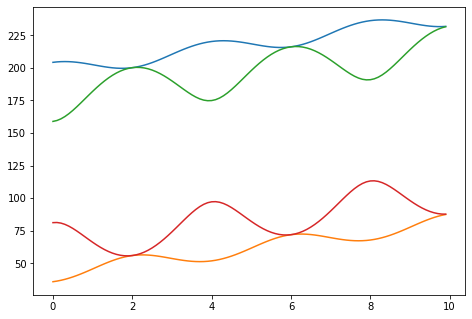

In [50]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(tt, Hh[0,:])
ax.plot(tt, Hh[1,:])
ax.plot(tt, Hh[2,:])
ax.plot(tt, Hh[3,:])
plt.show()

In [51]:
# https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
#from __future__ import print_function 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def drawRobot(robot, ax, u):
    # plot robot
    a = robot.a
    b = robot.b
    c = robot.c
    d = robot.d
    Xbase = np.array([a,-a,-a, a, a])/2.0
    Ybase = np.array([b, b, -b, -b, b])/2.0
    Zbase_top = np.ones(5)*robot.joint_pos_range[1]
     
    # draw base frame
    ax.plot(Xbase,Ybase, 'blue')
    ax.plot(Xbase,Ybase,Zbase_top, 'blue')
    ax.plot(np.array([a,a])/2.0,np.array([-b,-b])/2.0,robot.joint_pos_range, 'blue')
    ax.plot(np.array([a,a])/2.0,np.array([b,b])/2.0,robot.joint_pos_range, 'blue')
    ax.plot(np.array([-a,-a])/2.0,np.array([b,b])/2.0,robot.joint_pos_range, 'blue')
    ax.plot(np.array([-a,-a])/2.0,np.array([-b,-b])/2.0,robot.joint_pos_range, 'blue')
    
    # draw rods
    B_loc = np.transpose(np.array([[c/2.0, -d/2.0, 0 ,1],[c/2.0, d/2.0, 0 ,1], [-c/2.0, d/2.0, 0 ,1], [-c/2.0, -d/2.0, 0 ,1]]))
    B_abs = np.dot(TFtf[u,:,:], B_loc)
    ax.plot(np.array([a/2.0, B_abs[0,0]]),np.array([-b/2.0, B_abs[1,0]]), np.array([Hh[0,u], B_abs[2,0]]), 'green')
    ax.plot(np.array([a/2.0, B_abs[0,1]]),np.array([b/2.0, B_abs[1,1]]), np.array([Hh[1,u], B_abs[2,1]]), 'green')
    ax.plot(np.array([-a/2.0, B_abs[0,2]]),np.array([b/2.0, B_abs[1,2]]), np.array([Hh[2,u], B_abs[2,2]]), 'green')
    ax.plot(np.array([-a/2.0, B_abs[0,3]]),np.array([-b/2.0, B_abs[1,3]]), np.array([Hh[3,u], B_abs[2,3]]), 'green')
    
    # draw ee frame
    ax.plot(np.append(B_abs[0,:], B_abs[0,0]), np.append(B_abs[1,:],B_abs[1,0]), np.append(B_abs[2,:], B_abs[2,0]), 'red')
    
    # decorations
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')

def traj(u):
    #plt.ion() # don't need to use plt.show()
    t = tt[u]
    X = 15.0 + 15.0*np.cos(0.5 * np.pi * t)
    Y = 15.0*np.sin(0.5 * np.pi * t)
    Z = 120.0 + 4 * t
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(45, 45)
    ax.plot(Xx, Yy, Zz, label='des traj')
    ax.scatter(X, Y, Z, label='des pos')
    
    # manually set joint position of the robot
    robot.joint_pos = Hh[:,u]
    
    # draw robot
    drawRobot(robot, ax, u)
    set_axes_equal(ax)
    
    plt.show() 
    print("t =", t, " sec")

interact(traj, u=(0, len(tt)-1));
    

interactive(children=(IntSlider(value=49, description='u', max=99), Output()), _dom_classes=('widget-interact'…

# TO DO...
1. Add interface for choosing operation mode switching at  and geometric condition 
2. choose inverse kinematic solution cases corresponding to sigularity for each mode
3. Add plot of cureent inverse kinematic solution (and potential trajectory when switching modes)